# **EEP596: Natural Language Processing**

## Final Project - English-to-BASH

### Josh Shih, Qianyi Sha, Kevin Um

#### Download Huggingface transformer library, import required libraries, and connect all data

In [ ]:
!pip3 install -q git+https://github.com/huggingface/transformers.git
!pip3 install torch==1.2.0 torchvision==0.4.0 -f
!pip3 install datasets transformers[sentencepiece] sacrebleu
!pip3 install sacremoses
!pip3 install datasets

In [ ]:
import transformers

print(transformers.__version__)

4.27.0.dev0


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip install datasets

In [ ]:
# Importing libraries.
import pandas as pd
from sklearn.model_selection import train_test_split

import datasets

from datasets import load_dataset, load_metric
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import AutoTokenizer

import numpy as np

#### Data Preprocessing

In [ ]:
def load_csv(input, output):
  # Input: csv_file_name
  # Output: pandas data frame
  input_df = pd.read_csv(input, sep="\n", header=None, names=['input'])
  output_df = pd.read_csv(output, sep="\n", header=None, names=['output'])
  return input_df, output_df

In [ ]:
input, output = load_csv('balanced_user_input_NL2BASH.txt', 'balanced_commands_NL2BASH.txt')

overview = pd.concat([input, output], axis=1)
overview

,input,output
0,"Display process information twice, waiting one...","top -b -d2 -s1 | sed -e '1,/USERNAME/d' | sed ..."
1,Calculte and output amount of CPU load taken b...,top -b -n 1 -u abc | awk 'NR>7 { sum += $9; } ...
2,Display cumulative CPU usage over 5 seconds.,top -b -d 5 -n 2 | awk '$1 == PID {block_num++...
3,Display info on most CPU-intensive processes o...,top -n 1
4,Display information about number of processes ...,top -bn1 | grep zombie
...,...,...
11203,Read hexadecimal bytes from device /dev/midi22,od -vtx1 /dev/midi22
11204,Read hexadecimal bytes from device /dev/midi23,od -vtx1 /dev/midi23
11205,Read hexadecimal bytes from device /dev/midi24,od -vtx1 /dev/midi24
11206,Read hexadecimal bytes from device /dev/midi25,od -vtx1 /dev/midi25


##### View Data Distribution

In [ ]:
def cleaning(dataframe, original):
  dataframe = dataframe.str.replace("[\(\[].*?[\)\]] ",'', regex=True)
  dataframe = dataframe.str.replace('"', '', regex=True)
  # ----- Uncomment for overview dataframe
  if original == False:
    dataframe = dataframe.str.split(' ', n=1, expand=True) 
    dataframe = dataframe.rename(columns={0 : "command_1", 1 : "miscellaneous"})
  # -----
  return dataframe

In [ ]:
df_distribution = cleaning(overview['output'], original=False)
df_distribution

,command_1,miscellaneous
0,top,"-b -d2 -s1 | sed -e '1,/USERNAME/d' | sed -e '..."
1,top,-b -n 1 -u abc | awk 'NR>7 { sum += $9; } END ...
2,top,-b -d 5 -n 2 | awk '$1 == PID {block_num++; ne...
3,top,-n 1
4,top,-bn1 | grep zombie
...,...,...
11203,od,-vtx1 /dev/midi22
11204,od,-vtx1 /dev/midi23
11205,od,-vtx1 /dev/midi24
11206,od,-vtx1 /dev/midi25


<AxesSubplot:xlabel='command_1', ylabel='count'>

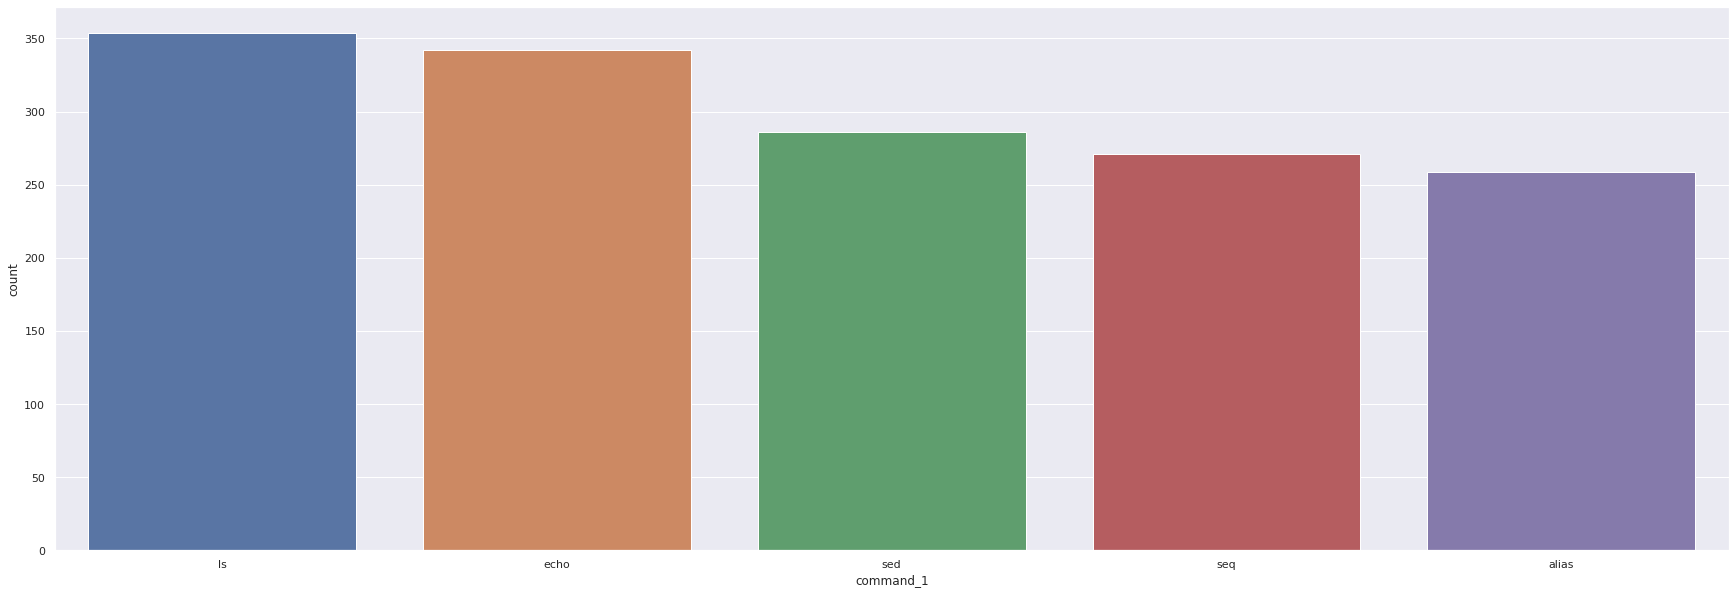

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(30,10)})

sns.countplot(x=df_distribution["command_1"], order=pd.value_counts(df_distribution["command_1"]).iloc[:5].index)

##### **Data Split**
*   Train: 10085 entries
*   Test: 1261 entries
*   Validation: 1261 entries

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input, output, train_size=0.8, test_size=0.2, shuffle=True, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size=0.5, test_size=0.5, shuffle=True, random_state=0)

train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)
valid = pd.concat([x_val, y_val], axis=1)

In [ ]:
train_dataset = Dataset.from_pandas(train)
train_dataset = train_dataset.remove_columns(["__index_level_0__"])

test_dataset = Dataset.from_pandas(test)
test_dataset = test_dataset.remove_columns(["__index_level_0__"])

valid_dataset = Dataset.from_pandas(valid)
valid_dataset = valid_dataset.remove_columns(["__index_level_0__"])

raw_datasets = DatasetDict({"train":train_dataset, "test":test_dataset, "valid":valid_dataset})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 8966
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 1121
    })
    valid: Dataset({
        features: ['input', 'output'],
        num_rows: 1121
    })
})

In [ ]:
raw_datasets['train'][400]

{'input': 'Counts the total number of lines in all the files in a git repository.',
 'output': 'git ls-files | xargs cat | wc -l'}

In [ ]:
raw_datasets['test'][30]

{'input': 'Print newline separated list of numbers from $start to $end',
 'output': "seq -s'\\n' $start $end"}

#### Fine-tuning: Load Model Checkpoint, Tokenizer, Metrics, Pretrained Weights

In [ ]:
model_checkpoint = 't5-small'
# model_checkpoint = 't5-large'
# model_checkpoint = 'google/t5-v1_1-base'
# model_checkpoint = 'google/byt5-small'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
max_input_length = 128
max_target_length = 128

def preprocess_function(examples):
    inputs = [ex for ex in examples['input']]
    targets = [ex for ex in examples['output']]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# !pip3 install sacrebleu
# metric = load_metric("sacrebleu")

!pip3 install evaluate
import evaluate
metric = evaluate.load("Josh98/nl2bash_m")

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-English-to-BASH",
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=True,
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

#### Initialize and Begin Training

In [ ]:

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"nl2bash_m": result["nl2bash_m"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/kevinum/byt5-small-finetuned-English-to-BASH into local empty directory.


Download file pytorch_model.bin:   0%|          | 32.0k/1.12G [00:00<?, ?B/s]

Download file runs/Feb23_07-33-50_0b693af2e148/1677137636.5079927/events.out.tfevents.1677137636.0b693af2e148.…

Download file runs/Feb23_07-39-50_0b693af2e148/1677137995.641755/events.out.tfevents.1677137995.0b693af2e148.1…

Download file runs/Feb24_08-42-48_c84210ab7f57/1677228490.3232696/events.out.tfevents.1677228490.c84210ab7f57.…

Download file runs/Feb24_08-42-48_c84210ab7f57/events.out.tfevents.1677228490.c84210ab7f57.872.0: 100%|#######…

Download file runs/Feb23_07-39-50_0b693af2e148/events.out.tfevents.1677137995.0b693af2e148.1222.4: 100%|######…

Download file runs/Feb23_07-33-50_0b693af2e148/events.out.tfevents.1677137636.0b693af2e148.1222.2: 100%|######…

Download file runs/Feb23_07-22-38_0b693af2e148/1677137028.6085584/events.out.tfevents.1677137028.0b693af2e148.…

Clean file runs/Feb23_07-33-50_0b693af2e148/1677137636.5079927/events.out.tfevents.1677137636.0b693af2e148.122…

Download file training_args.bin: 100%|##########| 3.62k/3.62k [00:00<?, ?B/s]

Clean file runs/Feb23_07-39-50_0b693af2e148/1677137995.641755/events.out.tfevents.1677137995.0b693af2e148.1222…

Download file runs/Feb23_07-22-38_0b693af2e148/events.out.tfevents.1677137028.0b693af2e148.1222.0: 100%|######…

Clean file runs/Feb24_08-42-48_c84210ab7f57/1677228490.3232696/events.out.tfevents.1677228490.c84210ab7f57.872…

Clean file runs/Feb23_07-39-50_0b693af2e148/events.out.tfevents.1677137995.0b693af2e148.1222.4:  11%|#        …

Clean file runs/Feb23_07-33-50_0b693af2e148/events.out.tfevents.1677137636.0b693af2e148.1222.2:  21%|##1      …

Clean file runs/Feb24_08-42-48_c84210ab7f57/events.out.tfevents.1677228490.c84210ab7f57.872.0:  12%|#1        …

Clean file runs/Feb23_07-22-38_0b693af2e148/1677137028.6085584/events.out.tfevents.1677137028.0b693af2e148.122…

Clean file training_args.bin:  28%|##7       | 1.00k/3.62k [00:00<?, ?B/s]

Clean file runs/Feb23_07-22-38_0b693af2e148/events.out.tfevents.1677137028.0b693af2e148.1222.0:  24%|##4      …

Clean file pytorch_model.bin:   0%|          | 1.00k/1.12G [00:00<?, ?B/s]

In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:346: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Nl2bash M,Gen Len
1,1.603100,0.867849,0.238400,16.941100
2,0.958100,0.693957,0.408900,17.285500
3,0.788200,0.604311,0.487800,17.148100
4,0.708000,0.568906,0.543900,17.142700


f_s:  0.23844305855502582
f_s:  0.40888793951671026
f_s:  0.48779718821740653
f_s:  0.5439427366003864


In [ ]:
trainer.push_to_hub()

# For Evaluation - Constrained Decoding

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DisjunctiveConstraint

tokenizer = AutoTokenizer.from_pretrained('alexsha/t5-large-finetuned-English-to-BASH')
model = AutoModelForSeq2SeqLM.from_pretrained('alexsha/t5-large-finetuned-English-to-BASH')

In [ ]:
encoder_input_str = "clears scrollback buffer"
constrained_list = [
    "ping", "SSH", "apt-get", "cat", "cd", "chmod", "clear", "cp", "dir", 
    "echo", "env", "free", "get", "kill", "ls", "mkdir", "mktemp", "mv", 
    "put", "pwd", "rm", "stat", "top", "touch", "tree", "rmdir"
    ]

constraints = [
    DisjunctiveConstraint(
        tokenizer(constrained_list, add_special_tokens=True).input_ids
        )
    ]

input_ids = tokenizer(encoder_input_str, return_tensors="pt").input_ids

outputs = model.generate(
    input_ids,
    constraints=constraints,
    num_beams=10,
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    remove_invalid_values=True,
    early_stopping=True,
    max_length=128,
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
clearstatus -c scrollback


In [ ]:
!pip3 install evaluate
import evaluate
metric = evaluate.load("Josh98/nl2bash_m")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 5.4 MB/s eta 0:00:00


In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"nl2bash_m": result["nl2bash_m"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
# Some simple post-processing
decoded_preds, decoded_labels = postprocess_text(["clear scrollback"], ["clear -x"])

result = metric.compute(predictions=decoded_preds, references=decoded_labels)
result

{'nl2bash_m': 0.65}

# Data Augmentation of NL2BASH Dataset

In [ ]:
!pip3 install openai

In [ ]:
import os
import openai
import pprint
import logging
import time


In [ ]:
def retrieve_text_pair(text):
    descriptions = []
    commands = []
    
    for line in text.split("\n"):
        line = line.strip()
        line = line.split(":")
        
        print(line)
        if "Description" in line:
            descriptions.append(':'.join(line[1:]))
            # print("descriptions: ", descriptions)
        elif "Command" in line:
            commands.append(':'.join(line[1:]))
            # print("commands: ", commands)
        else:
            pass
    valid_len = min(len(descriptions), len(commands)) - 1
    return descriptions[:valid_len], commands[:valid_len]

# text = """Description: when using vi-insert keymap bind command \\C-v} to key }\n\n
# Command: bind -m vi-insert \'"}" "\\C-v}"\'\n\n
# Description:  when using vi-insert keymap bind command \\C-v[ to key [\n\n
# Command: bind -m vi-insert \'"[" "\\C-v["\'\n\n"""


# text_pair = retrieve_text_pair(text)
# len(text_pair[0])

In [ ]:
def write_to_file(text_pair, description_path, command_path):
    description_file = open(description_path, 'a')
    command_file = open(command_path, 'a')
    for d, c in zip(text_pair[0], text_pair[1]): 
        description_file.write(d.strip()+'\n')
        command_file.write(c.strip()+'\n')
    description_file.close()
    command_file.close()

# write_to_file(text_pair, "output_description.txt", "output_command.txt")

In [ ]:
def get_response(num, description, command):
    prompt = \
    f"""Generate {num} similar bash commands and corresponding description:
    Description: {description}
    Command: {command}
    """

    response = openai.Completion.create(
    engine="text-davinci-002",
    prompt=prompt,
    temperature=0.0,
    max_tokens=4000,
    top_p=1.0,
    frequency_penalty=0.2,
    presence_penalty=0.2
    )
    return response.choices[0]["text"]
    # return response.choices[0]["text"]

In [ ]:
test_file = open('balanced_user_input.txt', 'r', encoding="utf8")
test_file_2 = open('balanced_commands.txt', 'r', encoding="utf8")
test_list = test_file.readlines()
test_list_2 = test_file_2.readlines()

for i, (des, com) in enumerate(zip(test_list, test_list_2)):
    try:
        print(i, des.strip(), com.strip())
        # first word of each user input: des.split()[0]
        delta = pd.value_counts(df_distribution_post["command_1"])[0] - pd.value_counts(df_distribution_post["command_1"]).loc[com.split()[0]]
        logging.info("running line: ",i)
        if delta > 200:
            text = get_response(delta, des, com)
            text_pair = retrieve_text_pair(text)
            write_to_file(text_pair, "output_description_v3.txt", "output_command_v3.txt")
        else:
            continue
        time.sleep(5)
    except Exception as e:
        logging.warn(i, "error: ", str(e))